### Machine Learning Project Part 2
#### Bahaar Khalilian and Hesam Mohebi
##### For the complete analysis of the project please check the report attached

##### First, we need to understand our task and what kind of model we want to use. So what we do is to load the training data and by analysing its properties, we can find out the type of solution we must implement.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.special import softmax
import scipy.spatial
# Specifying the path to the data files.
file_path1 = "training_X.npy"
file_path2 = "training_Y.npy"

# Loading them into a NumPy array
X = np.load(file_path1)
Y = np.load(file_path2)

# Printing the shape and type of the loaded array
print(f"Shape: {X.shape}, Data type: {X.dtype}")
print(f"Shape: {Y.shape}, Data type: {Y.dtype}")


Shape: (5200, 11), Data type: float64
Shape: (5200, 1), Data type: int64


### The training data icludes 5200 samples and 11 features

In [21]:
# To observe the data we use pandas and load the data into dataframes
x_df = pd.DataFrame(X)
y_df = pd.DataFrame(Y)

# How X looks:
x_df

,0,1,2,3,4,5,6,7,8,9,10
0,7.0,0.23,0.42,18.05,0.050,35.0,144.0,0.99990,3.22,0.42,8.8
1,8.3,0.33,0.43,9.20,0.046,22.0,126.0,0.99820,3.38,0.47,9.3
2,6.6,0.30,0.45,8.00,0.038,54.0,200.0,0.99560,3.18,0.48,9.5
3,7.5,0.58,0.14,2.20,0.077,27.0,60.0,0.99630,3.28,0.59,9.8
4,8.1,0.66,0.22,2.20,0.069,9.0,23.0,0.99680,3.30,1.20,10.3
...,...,...,...,...,...,...,...,...,...,...,...
5195,6.8,0.32,0.21,2.20,0.044,15.0,68.0,0.99320,3.17,0.39,9.4
5196,6.7,0.31,0.34,6.80,0.059,51.0,215.0,0.99538,3.33,0.56,10.3
5197,8.3,0.28,0.48,2.10,0.093,6.0,12.0,0.99408,3.26,0.62,12.4
5198,7.0,0.12,0.19,4.90,0.055,27.0,127.0,0.99530,3.29,0.41,9.4


In [22]:
# How Y looks:
y_df

,0
0,5
1,5
2,5
3,5
4,5
...,...
5195,6
5196,5
5197,7
5198,5


Unique values and their counts: {3: 24, 4: 176, 5: 1724, 6: 2272, 7: 846, 8: 154, 9: 4}


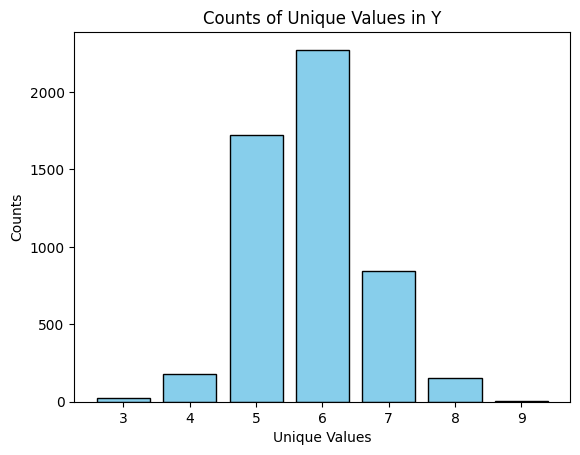

In [23]:
# Counting samples of each unique value in Y
unique, counts = np.unique(Y, return_counts=True)
print(f"Unique values and their counts: {dict(zip(unique, counts))}")
plt.bar(unique, counts, color='skyblue', edgecolor='black')
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Counts of Unique Values in Y')
plt.show()

### In the next section we include the essential functions which we used during the hands-on Lab assignments. We only apply small changes to fit the function to our current problem. For example, as we are using the Gaussian Kernel, there is no need for a variable kernel-type. We also add some functions that we use to accomplish classification using KRLS.

In [24]:
# the neccessary funcs as defined in the assignment:
def calc_err(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

def squared_distances(X1, X2):
    """Compute the matrix of pairwise squared-distances between all points in X1 and in X2.
    """
    return scipy.spatial.distance.cdist(X1, X2, metric='seuclidean')

def Gaussian_Kernel(X1, X2, param):
    # X1 : array of shape n x d
    # X2 : array of shape m x d
    lengthscale = param
    sq_dists = squared_distances(X1, X2)
    return np.exp(-sq_dists / (2 * (lengthscale ** 2)))

def krls_train(x, y, reg_par, kernel_par):
    n = x.shape[0]
    K = Gaussian_Kernel(x, x, kernel_par)
    K_reg = K + n * reg_par * np.eye(n)
    w = np.linalg.solve(K_reg, y)
    return w

def krls_predict(x_ts, x_tr, w, kernel_par):
    K_ts = Gaussian_Kernel(x_ts, x_tr, kernel_par)
    return np.dot(K_ts, w)

def encode_labels(Y):
    """Encode integer class labels into one-hot encoding."""
    encoder = OneHotEncoder(sparse_output=False)
    return encoder.fit_transform(Y.reshape(-1, 1)), encoder

def compute_probabilities(scores):
    """Convert raw scores to probabilities using the softmax function."""
    return softmax(scores, axis=1)

#### Our proposed solution is:
##### We train a KRLS model for each class using the samples provided for each class. Then we use the calcultaed weights for each class to predict the score for each class. Then we calculate the probabilities of a point belonging to each class. We consider the class with the highest probability as the final prediction of the model for that data point.
#### We use Q-fold cross-validation to choose the best hyperparameters for the regularizer and the kernel.

In [25]:
def krls_kfold_valerr_multiclass(x_tr, y_tr, num_folds, reg_par, kernel_par):
    """
    Compute the k-fold cross-validation error for one KRLS model (with speficied regularization, 
    kernel and kernel parameter).
    
    This function returns both the training errors and the validation errors 
    obtained from CV (as numpy arrays).
    """
    if num_folds <= 1:
        raise Exception("Please supply a number of folds > 1")

    n_tot = x_tr.shape[0]
    n_val = int(n_tot // num_folds)
    n_classes = y_tr.shape[1] # number of classes in one-hot encoding

    tr_errs, val_errs = [], []

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)

    for fold in tqdm(range(num_folds),desc=f"Processing folds (lambda={reg_par}, kernel_par={kernel_par})"):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold]] = True
        
        kf_x_tr = x_tr[~val_mask]
        kf_y_tr = y_tr[~val_mask]
        kf_x_val = x_tr[val_mask]
        kf_y_val = y_tr[val_mask]

        # Traind and predict for each class
        tr_scores, val_scores = [], []
        for class_idx in tqdm(range(n_classes),desc=f"Processing classes (fold={fold + 1})", leave=False):
            w_krls = krls_train(kf_x_tr, kf_y_tr[:, class_idx],reg_par=reg_par, kernel_par=kernel_par) # calculating weight for each class

            tr_scores.append(krls_predict(kf_x_tr, kf_x_tr, w_krls, kernel_par=kernel_par)) # predicting for training data
            val_scores.append(krls_predict(kf_x_val, kf_x_tr, w_krls, kernel_par=kernel_par)) # predicting for validation data
        
        tr_scores = np.stack(tr_scores, axis=1)
        val_scores = np.stack(val_scores, axis=1)

        tr_probs = compute_probabilities(tr_scores)
        val_probs = compute_probabilities(val_scores)

        # predict classes and calculate errors
        tr_preds = np.argmax(tr_probs, axis=1)
        val_preds = np.argmax(val_probs, axis=1)

        # calculate errors
        tr_errs.append(calc_err(tr_preds, np.argmax(kf_y_tr, axis=1)))
        val_errs.append(calc_err(val_preds, np.argmax(kf_y_val, axis=1)))

    return np.asarray(tr_errs), np.asarray(val_errs)


In [26]:
def krls_kfoldcv_multiclass(x_tr, y_tr, num_folds, reg_par_list, kernel_par_list):
    """Choose the best parameters for both the regularizer and the kernel parameter according to K-Fold CV.
    """
    Val_errors = np.zeros((len(reg_par_list), len(kernel_par_list)))
    Tr_errors = np.zeros((len(reg_par_list), len(kernel_par_list)))
    for i, reg_par in enumerate(reg_par_list):
        for j, kernel_par in enumerate(kernel_par_list):
            tr_error, val_error = krls_kfold_valerr_multiclass(x_tr, y_tr, num_folds, reg_par, kernel_par) # calculating training and validation error
            Val_errors[i][j] = np.mean(val_error)
            Tr_errors[i][j] = np.mean(tr_error)
            print(f"The Validation error for lambda={reg_par}, kernel-parameter={kernel_par} is {np.mean(val_error)*100:.2f}%")
            print(f"The Train error for lambda={reg_par}, kernel-parameter={kernel_par} is {np.mean(tr_error)*100:.2f}%")

    best_reg_par = reg_par_list[np.unravel_index(np.argmin(Val_errors), Val_errors.shape)[0]]
    best_kernel_par = kernel_par_list[np.unravel_index(np.argmin(Val_errors), Val_errors.shape)[1]]
    best_err = np.min(Val_errors)
    print(f"The best error (MSE={best_err*100:.2f}%) was obtained with "
          f"lambda={best_reg_par}, kernel-parameter={best_kernel_par}")
    return best_reg_par, best_kernel_par, best_err, Val_errors, Tr_errors

#### First we obtained the Validaton error: 48.42% with best parameters lambda: 0.001 and Kernel parameter: 0.5. 
#### After consulting the error plots ( you can see these in the report) we decided to extend the range of our hyperparameters to include smaller values and trained and evaluated the model on this new range as well.
#### The new error is at 44% making it a better result than the last one. Finally seeing as the error doesn not change with smaller values, we declare the new best hyperparametrs as our final ones.

In [27]:
# Data Standardization
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Encoding Y into one-hot
Y_encoded, encoder = encode_labels(Y)

# small hyperparameter list
# reg_par_list = [1e-2, 10]
# kernel_par_list = [0.5, 1, 2]
# num_folds = 3

# Define parameter ranges
# reg_par_list = [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 2000]
# kernel_par_list = [0.1, 0.5, 1, 2, 10, 20]
# num_folds = 5

# trying smaller reg_par
reg_par_list = [1e-5,1e-4,1e-3]
kernel_par_list = [0.1, 0.5, 1, 2, 10]
num_folds = 5

# perform KF_CV_multiclass to find the best parameters for 
print("Starting K-Fold Cross Validation...")
best_reg_par, best_kernel_par, best_err, Val_erros, Tr_erros = krls_kfoldcv_multiclass(X_standardized, Y_encoded, num_folds, reg_par_list, kernel_par_list)

# train final model
print(f"\nBest parameters found: \n Regularization parameter: {best_reg_par} \n Kernel parameter: {best_kernel_par}")
print(f"Cross Validation error: {best_err*100:.2f}%")


Starting K-Fold Cross Validation...


Processing folds (lambda=1e-05, kernel_par=0.1): 100%|██████████| 5/5 [00:57<00:00, 11.52s/it]


The Validation error for lambda=1e-05, kernel-parameter=0.1 is 468.65%
The Train error for lambda=1e-05, kernel-parameter=0.1 is 0.00%


Processing folds (lambda=1e-05, kernel_par=0.5): 100%|██████████| 5/5 [00:48<00:00,  9.72s/it]


The Validation error for lambda=1e-05, kernel-parameter=0.5 is 46.79%
The Train error for lambda=1e-05, kernel-parameter=0.5 is 0.00%


Processing folds (lambda=1e-05, kernel_par=1): 100%|██████████| 5/5 [00:45<00:00,  9.03s/it]


The Validation error for lambda=1e-05, kernel-parameter=1 is 48.04%
The Train error for lambda=1e-05, kernel-parameter=1 is 0.00%


Processing folds (lambda=1e-05, kernel_par=2): 100%|██████████| 5/5 [00:48<00:00,  9.73s/it]


The Validation error for lambda=1e-05, kernel-parameter=2 is 48.44%
The Train error for lambda=1e-05, kernel-parameter=2 is 0.00%


Processing folds (lambda=1e-05, kernel_par=10): 100%|██████████| 5/5 [00:43<00:00,  8.77s/it]


The Validation error for lambda=1e-05, kernel-parameter=10 is 53.81%
The Train error for lambda=1e-05, kernel-parameter=10 is 40.23%


Processing folds (lambda=0.0001, kernel_par=0.1): 100%|██████████| 5/5 [00:55<00:00, 11.17s/it]


The Validation error for lambda=0.0001, kernel-parameter=0.1 is 480.52%
The Train error for lambda=0.0001, kernel-parameter=0.1 is 0.00%


Processing folds (lambda=0.0001, kernel_par=0.5): 100%|██████████| 5/5 [00:41<00:00,  8.38s/it]


The Validation error for lambda=0.0001, kernel-parameter=0.5 is 46.10%
The Train error for lambda=0.0001, kernel-parameter=0.5 is 0.00%


Processing folds (lambda=0.0001, kernel_par=1): 100%|██████████| 5/5 [00:47<00:00,  9.47s/it]


The Validation error for lambda=0.0001, kernel-parameter=1 is 46.71%
The Train error for lambda=0.0001, kernel-parameter=1 is 0.38%


Processing folds (lambda=0.0001, kernel_par=2): 100%|██████████| 5/5 [00:52<00:00, 10.57s/it]


The Validation error for lambda=0.0001, kernel-parameter=2 is 50.79%
The Train error for lambda=0.0001, kernel-parameter=2 is 22.70%


Processing folds (lambda=0.0001, kernel_par=10): 100%|██████████| 5/5 [00:47<00:00,  9.51s/it]


The Validation error for lambda=0.0001, kernel-parameter=10 is 58.79%
The Train error for lambda=0.0001, kernel-parameter=10 is 56.32%


Processing folds (lambda=0.001, kernel_par=0.1): 100%|██████████| 5/5 [00:58<00:00, 11.79s/it]


The Validation error for lambda=0.001, kernel-parameter=0.1 is 493.85%
The Train error for lambda=0.001, kernel-parameter=0.1 is 0.00%


Processing folds (lambda=0.001, kernel_par=0.5): 100%|██████████| 5/5 [00:42<00:00,  8.45s/it]


The Validation error for lambda=0.001, kernel-parameter=0.5 is 48.67%
The Train error for lambda=0.001, kernel-parameter=0.5 is 11.00%


Processing folds (lambda=0.001, kernel_par=1): 100%|██████████| 5/5 [00:42<00:00,  8.57s/it]


The Validation error for lambda=0.001, kernel-parameter=1 is 54.54%
The Train error for lambda=0.001, kernel-parameter=1 is 40.81%


Processing folds (lambda=0.001, kernel_par=2): 100%|██████████| 5/5 [00:43<00:00,  8.70s/it]


The Validation error for lambda=0.001, kernel-parameter=2 is 56.60%
The Train error for lambda=0.001, kernel-parameter=2 is 52.02%


Processing folds (lambda=0.001, kernel_par=10): 100%|██████████| 5/5 [00:47<00:00,  9.40s/it]

The Validation error for lambda=0.001, kernel-parameter=10 is 66.71%
The Train error for lambda=0.001, kernel-parameter=10 is 66.38%
The best error (MSE=46.10%) was obtained with lambda=0.0001, kernel-parameter=0.5

Best parameters found: 
 Regularization parameter: 0.0001 
 Kernel parameter: 0.5
Cross Validation error: 46.10%


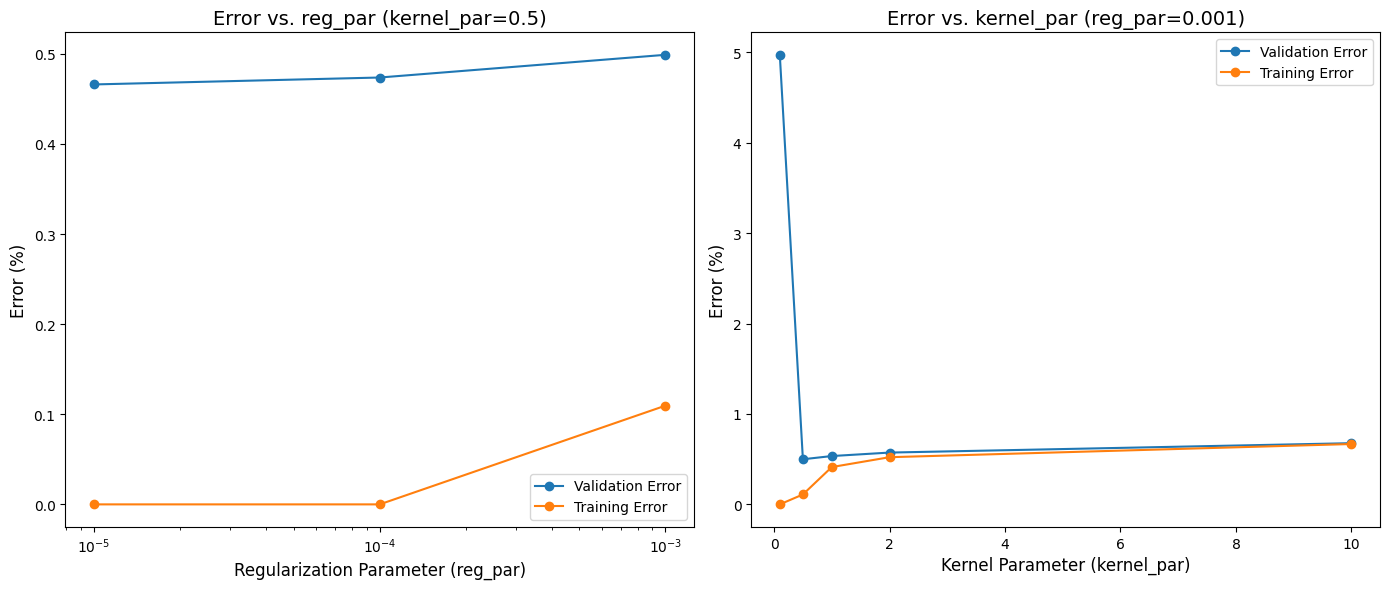

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

reg_par_values = np.array(reg_par_list)
kernel_par_values = np.array(kernel_par_list)
validation_errors = np.array(Val_erros)
train_errors = np.array(Tr_erros)

# 1. Line Graphs
fixed_kernel_index = 1  # Corresponds to kernel_par = 0.5
fixed_reg_index = 2  # Corresponds to reg_par = 0.1

plt.figure(figsize=(14, 6))

# Line graph for reg_par
plt.subplot(1, 2, 1)
plt.plot(reg_par_values, validation_errors[:, fixed_kernel_index], label="Validation Error", marker='o')
plt.plot(reg_par_values, train_errors[:, fixed_kernel_index], label="Training Error", marker='o')
plt.title(f"Error vs. reg_par (kernel_par={kernel_par_values[fixed_kernel_index]})", fontsize=14)
plt.xlabel("Regularization Parameter (reg_par)", fontsize=12)
plt.ylabel("Error (%)", fontsize=12)
plt.legend()
plt.xscale("log")

# Line graph for kernel_par
plt.subplot(1, 2, 2)
plt.plot(kernel_par_values, validation_errors[fixed_reg_index, :], label="Validation Error", marker='o')
plt.plot(kernel_par_values, train_errors[fixed_reg_index, :], label="Training Error", marker='o')
plt.title(f"Error vs. kernel_par (reg_par={reg_par_values[fixed_reg_index]})", fontsize=14)
plt.xlabel("Kernel Parameter (kernel_par)", fontsize=12)
plt.ylabel("Error (%)", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


### now we do one final training using our best parameters

In [28]:
# Final training and validation using the best parameters
from sklearn.model_selection import train_test_split

# Split data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_standardized, Y_encoded, test_size=0.2, random_state=42)

# Train the final model
n_classes = Y_encoded.shape[1] # number of classes
final_weights = []

best_reg_par = 1e-5
best_kernel_par = 0.5
print("Training the final model with best parameters...")
for class_idx in tqdm(range(n_classes), desc="Training for each class"):
    w_final = krls_train(X_train, Y_train[:, class_idx], reg_par=best_reg_par, kernel_par=best_kernel_par)
    final_weights.append(w_final)

final_weights = np.stack(final_weights, axis=1)


class_scores = []

for class_idx in range(final_weights.shape[1]):
    # extract the weights for current class
    class_weights = final_weights[:, class_idx]

    # predict the score for the corrent class using the weights
    class_score = krls_predict(X_val, X_train, class_weights, kernel_par=best_kernel_par)

    # Append the predicted scores to the list
    class_scores.append(class_score)

# Stack the scores for all classes into a single array
final_scores_val = np.stack(class_scores, axis=1)

# Compute probabilities using softmax
final_probs_val = compute_probabilities(final_scores_val)

# Predict classes
final_preds_val = np.argmax(final_probs_val, axis=1)
true_classes_val = np.argmax(Y_val, axis=1)

# Compute the final validation error
final_val_err = calc_err(final_preds_val, true_classes_val)

print(f"\nFinal validation error using best parameters: {final_val_err * 100:.2f}%")


Training the final model with best parameters...


Training for each class: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]



Final validation error using best parameters: 44.13%


#### Test Cell: 
##### Please load the testing dataset using the code cell below:

In [15]:
Xte = np.load("testing_X.npy")
Yte = np.load("testing_Y.npy")

print(f"Shape: {Xte.shape}, Data type: {Xte.dtype}")
print(f"Shape: {Yte.shape}, Data type: {Yte.dtype}")

# Standardization of the data
Xte_standardized = scaler.fit_transform(Xte)

# Encoding Y into one-hot
Yte_encoded, te_encoder = encode_labels(Yte)

test_class_scores = []

# Predicting scores for each class
print("Predicting test data...")
for class_idx in range(final_weights.shape[1]):
    # Calculating the weights for each class
    class_weights = final_weights[:, class_idx]
    
    # Predicting the score for the current class
    test_class_score = krls_predict(Xte_standardized, X_train, class_weights, kernel_par=best_kernel_par)
    test_class_scores.append(test_class_score)

# Stack the scores for all classes into a single array
final_scores_test = np.stack(test_class_scores, axis=1)

# Compute probabilities using softmax
final_probs_test = compute_probabilities(final_scores_test)

# Predict classes
final_preds_test = np.argmax(final_probs_test, axis=1)
true_classes_test = np.argmax(Yte_encoded, axis=1)

# Compute the final test error
final_test_err = calc_err(final_preds_test, true_classes_test)

print(f"\nFinal test error using best parameters: {final_test_err * 100:.2f}%")

Shape: (5200, 11), Data type: float64
Shape: (5200, 1), Data type: int64
Predicting test data...

Final test error using best parameters: 8.83%
